# CSC3831 Final Assessment - Part I: Data Engineering



In [168]:
# Loading in standard packages for analysis, feel free to add an extra packages you'd like to use here
import random
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import requests
from io import StringIO
import urllib3
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

urllib3.disable_warnings()

url = 'https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/CORRUPTED/HOUSES/houses_0.1_MAR.csv'
response = requests.get(url, verify=False)  # Disable SSL verification

# Load the content into pandas
houses_corrupted = pd.read_csv(StringIO(response.text))
houses_corrupted.drop(["Unnamed: 0"], axis=1, inplace=True)

Above we've loaded in a corrupted version of a housing dataset. The anomalies need to be dealt with and missing values imputed.

### 1. Data Understanding [7]
- Perform ad hoc EDA to understand and describe what you see in the raw dataset
  - Include graphs, statistics, and written descritpions as appropriate
  - Any extra information about the data you can provide here is useful, think about performing an analysis (ED**A**), what would you find interesting or useful?
- Identify features with missing records, outlier records


Goal: To analyse and investigate datasets to summarise and visualise their main characteristics, often with visual methods.

In [7]:
houses_corrupted.columns

Index(['median_house_value', 'median_income', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude',
       'longitude'],
      dtype='object')

In [6]:
houses_corrupted.head(10)

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,NaN,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,NaN,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25
5,269700.0,4.0368,52.0,919.0,213.0,413.0,193.0,37.85,-122.25
6,299200.0,3.6591,52.0,2535.0,489.0,1094.0,514.0,37.84,-122.25
7,241400.0,3.1200,52.0,3104.0,687.0,1157.0,647.0,37.84,-122.25
8,226700.0,2.0804,42.0,2555.0,665.0,1206.0,595.0,37.84,-122.26
9,261100.0,3.6912,52.0,3549.0,707.0,1551.0,714.0,37.84,-122.25


Following gives an overview of the relationships between the features in the dataset. The diagonal shows the distribution of the data for each feature, helping us to identify the distribution of the data i.e., normal or skewed. If the distribution is skewed, we can apply transformations to make the data normal.

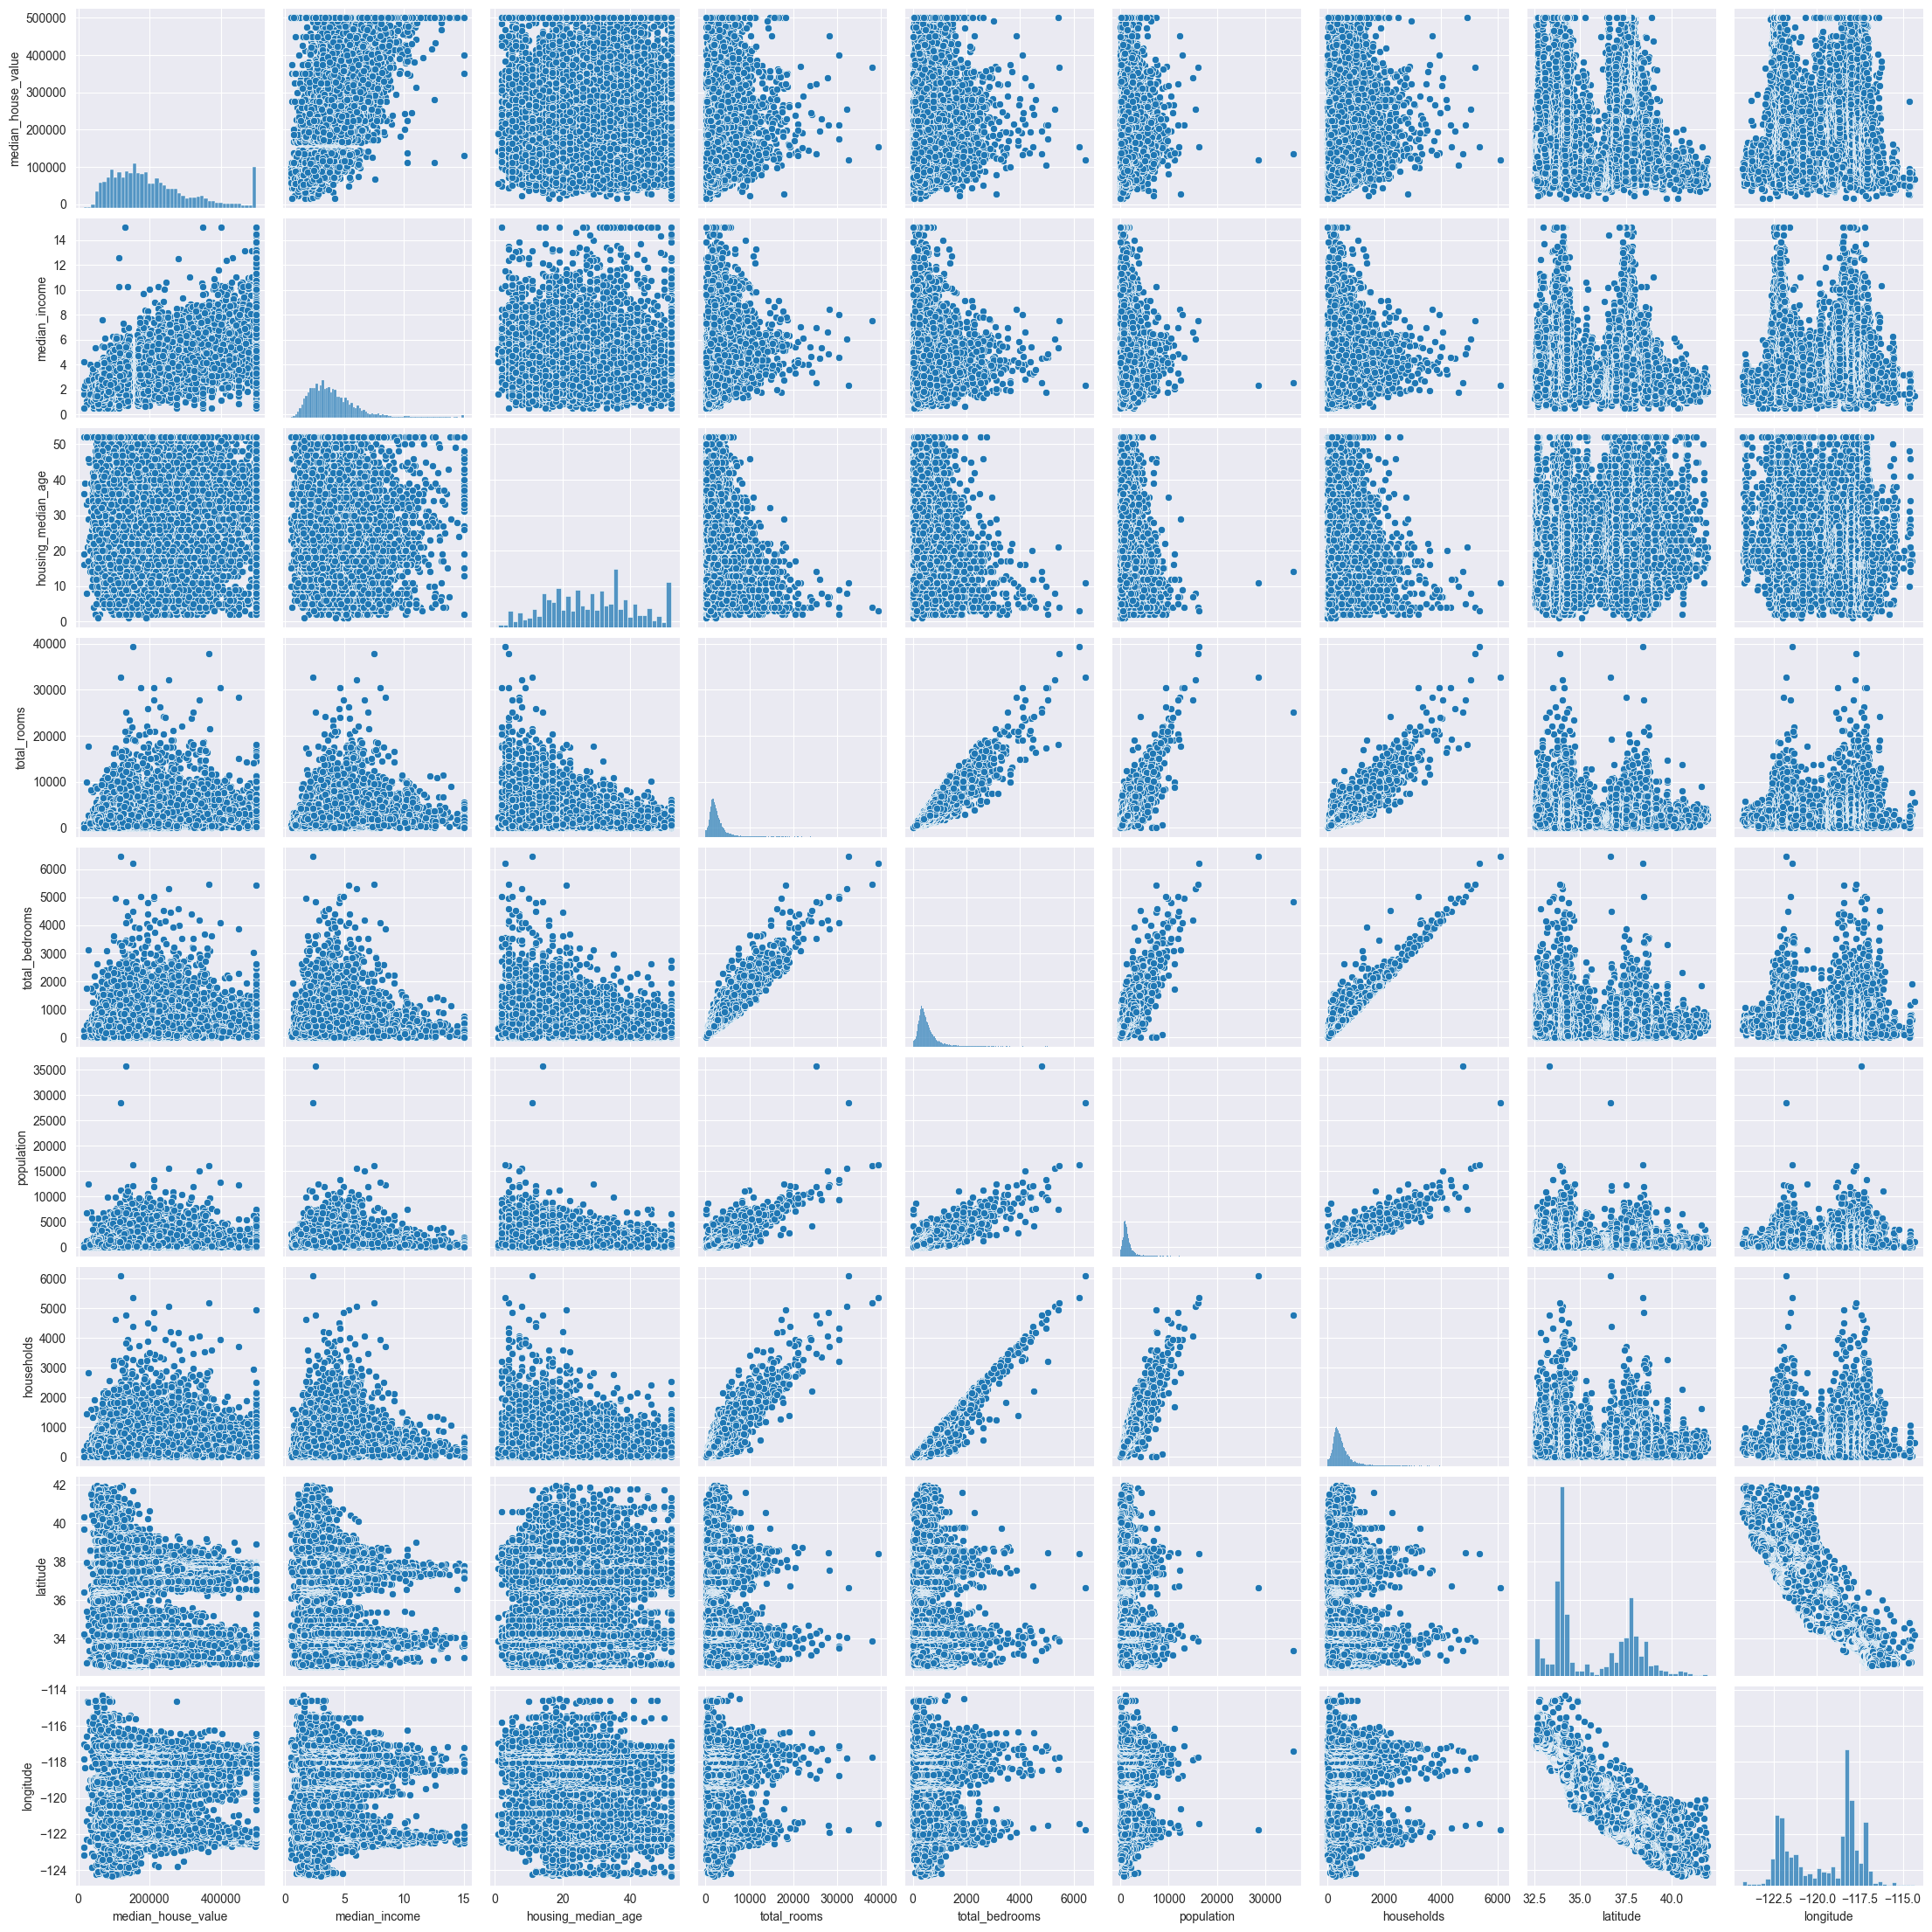

In [8]:
sns.pairplot(houses_corrupted)

<Axes: xlabel='median_house_value', ylabel='Density'>

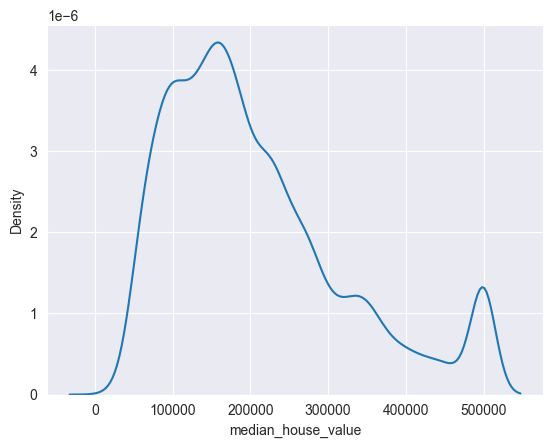

In [9]:
sns.kdeplot(houses_corrupted['median_house_value'])

<Axes: xlabel='median_income', ylabel='Density'>

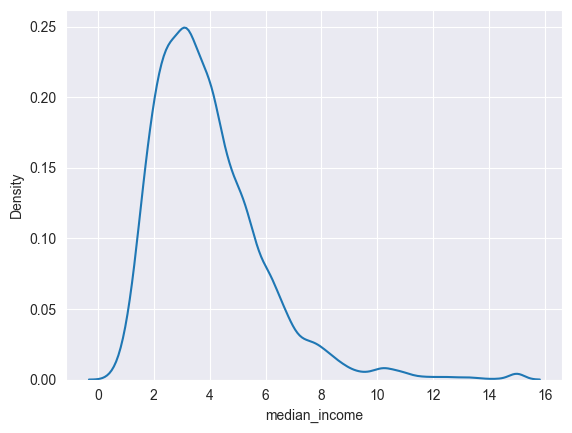

In [10]:
sns.kdeplot(houses_corrupted['median_income'])

<Axes: xlabel='total_rooms', ylabel='Density'>

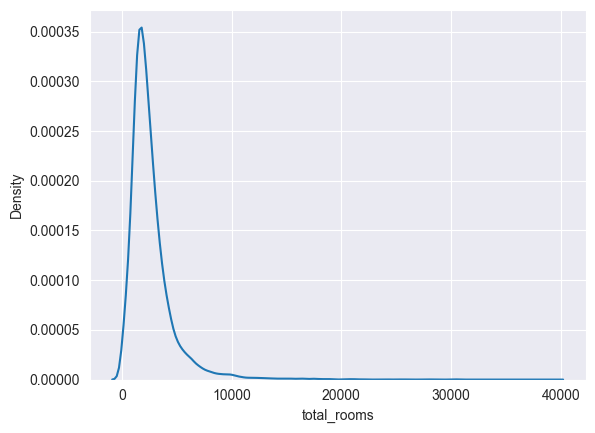

In [11]:
sns.kdeplot(houses_corrupted['total_rooms'])

<Axes: xlabel='housing_median_age', ylabel='Density'>

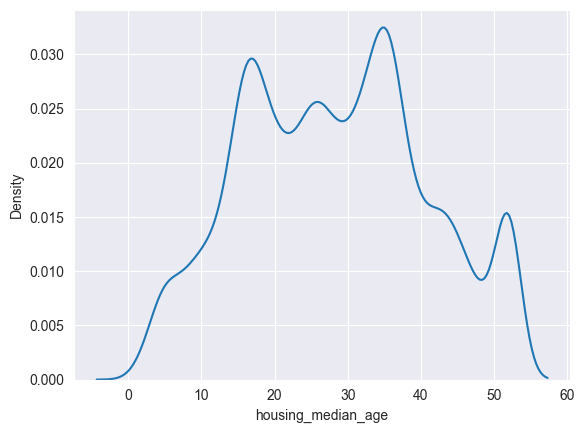

In [12]:
sns.kdeplot(houses_corrupted['housing_median_age'])

<Axes: xlabel='households', ylabel='Density'>

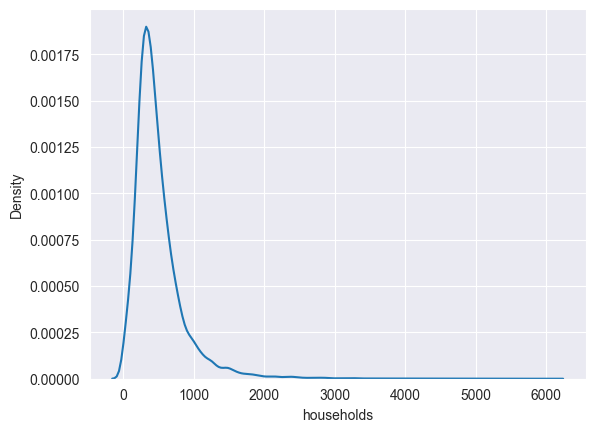

In [13]:
sns.kdeplot(houses_corrupted['households'])

<Axes: xlabel='total_bedrooms', ylabel='Density'>

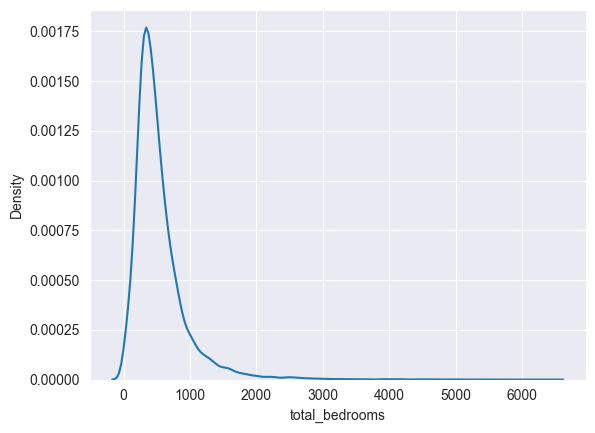

In [14]:
sns.kdeplot(houses_corrupted['total_bedrooms'])

<Axes: xlabel='population', ylabel='Density'>

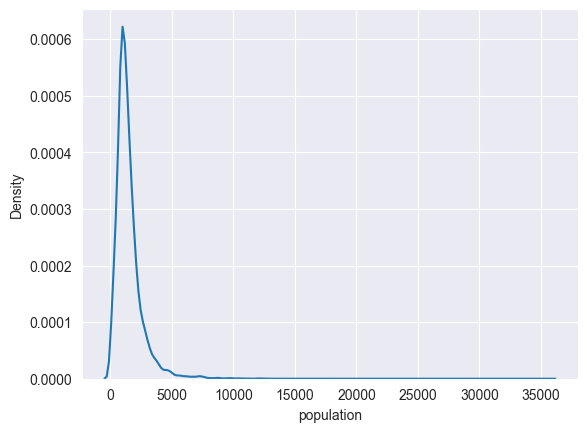

In [15]:
sns.kdeplot(houses_corrupted['population'])

<Axes: xlabel='latitude', ylabel='Density'>

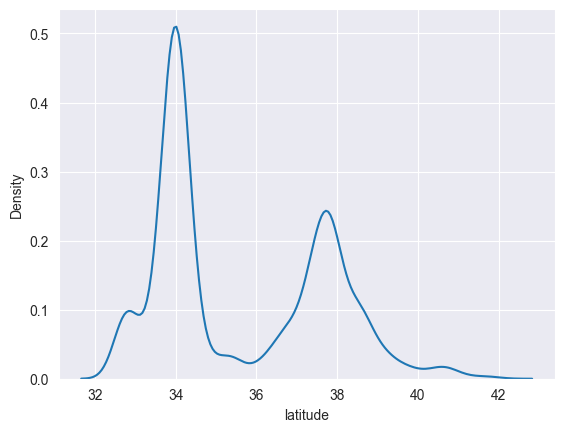

In [16]:
sns.kdeplot(houses_corrupted['latitude'])

<Axes: xlabel='longitude', ylabel='Density'>

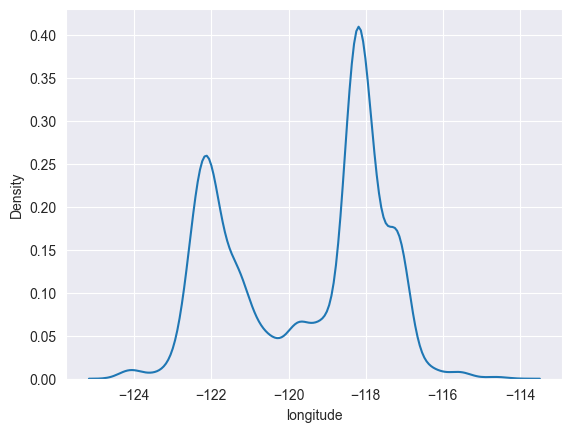

In [17]:
sns.kdeplot(houses_corrupted['longitude'])

In [18]:
houses_corrupted.describe()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
count,20640.000000,18576.000000,18576.000000,20640.000000,20640.000000,18576.000000,20640.000000,20640.000000,20640.000000
mean,206855.816909,3.929958,28.324182,2635.763081,537.898014,1488.069283,499.539680,35.631861,-119.569704
std,115395.615874,1.964296,12.584914,2181.615252,421.247906,1170.585810,382.329753,2.135952,2.003532
min,14999.000000,0.499900,1.000000,2.000000,1.000000,3.000000,1.000000,32.540000,-124.350000
25%,119600.000000,2.560300,18.000000,1447.750000,295.000000,839.000000,280.000000,33.930000,-121.800000
50%,179700.000000,3.572400,28.000000,2127.000000,435.000000,1227.000000,409.000000,34.260000,-118.490000
75%,264725.000000,4.870050,37.000000,3148.000000,647.000000,1803.000000,605.000000,37.710000,-118.010000
max,500001.000000,15.000100,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,41.950000,-114.310000


As mean and standard deviation should be used for normal values, but median (50% percentile) and MAD should be used for skewed data.

In [140]:
houses_corrupted_MAD = pd.DataFrame(columns = houses_corrupted.columns)
MADS = []
for attribute in houses_corrupted.columns:
  mad = 1.483 * abs(houses_corrupted[attribute] - houses_corrupted[attribute].median()).median()
  MADS.append(mad)
houses_corrupted_MAD.loc[0] = MADS
print(houses_corrupted_MAD)

   median_house_value  median_income  housing_median_age  total_rooms  \
0            101437.2       1.660515              13.347     1181.951   

   total_bedrooms  population  households  latitude  longitude  
0         241.729     670.316     223.933   1.82409    1.89824  


Since the dataset is skewed, we cant correlate between the attributes. Let's try to fix the skew by applying a log transformation. Will play around with the outliers in the next section to completely fix the skew.

In [55]:
houses_corrupted_log = np.log(houses_corrupted+125)  # Adding 125 to avoid log(0) error
houses_corrupted_log.describe()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
count,20640.000000,18576.000000,18576.000000,20640.000000,20640.000000,18576.000000,20640.000000,20640.000000,20640.000000
mean,12.085716,4.859155,5.029177,7.709283,6.357756,7.196336,6.305626,5.079027,1.606693
std,0.568649,0.015061,0.082283,0.661322,0.508377,0.623246,0.496320,0.013258,0.440421
min,9.624038,4.832305,4.836282,4.844187,4.836282,4.852030,4.836282,5.059679,-0.430783
25%,11.692953,4.848589,4.962845,7.360581,6.040255,6.871091,6.003887,5.068464,1.163151
50%,12.099739,4.856492,5.030438,7.719574,6.327937,7.209340,6.280396,5.070538,1.873339
75%,12.486919,4.866534,5.087596,8.093462,6.648985,7.564238,6.593045,5.091969,1.944481
max,13.122615,4.941643,5.176150,10.582663,8.790269,10.485899,8.733433,5.117694,2.369309


### 2. Outlier Identification [10]

- Utilise a statistical outlier detection approach (i.e., no KNN, LOF, 1Class SVM)
- Utilise an algorithmic outlier detection method of your choice
- Compare results and decide what to do with identified outleirs
  - Include graphs, statistics, and written descriptions as appropriate
- Explain what you are doing, and why your analysis is appropriate
- Comment on benefits/detriments of statistical and algorithmic outlier detection approaches

Goal: To identify and remove outliers from the dataset.



I started with preprocessing the data by applying Min-Max scaling to normalize the logarithmic data.

In [144]:
#Log transformation followed by Min-Max scaling
houses_corrupted_cleaned = houses_corrupted.dropna()  # Drop rows with missing values
houses_log_transformed = np.log1p(houses_corrupted_cleaned+125)  # Apply log transformation
scaler = MinMaxScaler()  # Initialize scaler
houses_preprocessed = scaler.fit_transform(houses_log_transformed) # Apply scaling
houses_preprocessed = pd.DataFrame(houses_preprocessed, columns=houses_corrupted_cleaned.columns)  # Convert to DataFrame

68-95-99.7 rule: 68% of the data falls within 1 standard deviation, 95% within 2 standard deviations, and 99.7% within 3 standard deviations. So it is safe to assume that anything outside of 3 standard deviations is an outlier.

In [145]:
# Calculate the median for each column
median_values = houses_preprocessed.median()

# Calculate the Median Absolute Deviation (MAD) for each column
# MAD = median(|X - median(X)|)
mad_values = (houses_preprocessed - median_values).abs().median()

# Adjust MAD to make it comparable to the standard deviation
scaled_mad_values = mad_values * 1.483

# Define the outlier boundaries using the median and scaled MAD
lower_bound = median_values - (3 * scaled_mad_values)
upper_bound = median_values + (3 * scaled_mad_values)

# Flag outliers based on the 68-95-99.7 Rule with Median and MAD
outliers = ((houses_preprocessed < lower_bound) | (houses_preprocessed > upper_bound))
outliers_only = houses_preprocessed[outliers.any(axis=1)]

print("Outliers based on the 68-95-99.7 Rule with Median and MAD:")
print(len(outliers_only))
outliers_only.head(10)

Outliers based on the 68-95-99.7 Rule with Median and MAD:
1658


,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
37,0.394480,0.149040,0.023232,0.139938,0.072401,0.094882,0.093922,0.568187,0.416761
39,0.458143,0.400448,0.949651,0.125109,0.050488,0.088298,0.041075,0.568187,0.416761
49,0.428080,0.000000,0.898432,0.013209,0.005916,0.019552,0.011869,0.567129,0.416761
54,0.573879,0.048446,1.000000,0.169462,0.091180,0.155263,0.092513,0.567129,0.419526
55,0.573879,0.074070,1.000000,0.226894,0.142664,0.164782,0.132952,0.567129,0.418145
60,0.631180,0.034341,0.202810,0.103668,0.070897,0.118313,0.067300,0.566070,0.419526
61,1.000000,0.054002,1.000000,0.188745,0.120098,0.248458,0.130527,0.566070,0.419526
64,0.615163,0.109324,0.721007,0.658873,0.765346,0.591436,0.760848,0.566070,0.420903
66,0.603963,0.109079,0.590166,0.225000,0.153780,0.165870,0.137736,0.567129,0.420903
85,0.885564,0.319605,0.739235,0.224619,0.088380,0.098084,0.079473,0.571363,0.423646


Using a Robust Z-score method to identify outliers. The Robust Z-score is calculated by dividing the deviation from the median by the median absolute deviation (MAD). The MAD is a robust measure of the variability of a univariate sample of quantitative data.

In [146]:
# Calculate the median and MAD for each column
median_values = houses_preprocessed.median()

# Calculate the robust Z-score for each element
robust_z_scores = 0.6745 * (houses_preprocessed - median_values) / scaled_mad_values

# Flag values where the robust Z-score is greater than 3
outliers_robust_z = (robust_z_scores.abs() > 3)
# Filter and print only the rows with True values (i.e., only the outliers)
outliers_robust_z_only = houses_preprocessed[outliers_robust_z.any(axis=1)]
print("Outliers based on Robust Z-score:")
print(len(outliers_robust_z_only))
print(outliers_robust_z_only)

Outliers based on Robust Z-score:
372
       median_house_value  median_income  housing_median_age  total_rooms  \
49               0.428080       0.000000            0.898432     0.013209   
60               0.631180       0.034341            0.202810     0.103668   
93               0.930899       0.775179            0.372119     0.458533   
347              1.000000       0.792481            0.775359     0.529965   
348              1.000000       0.827181            1.000000     0.586869   
...                   ...            ...                 ...          ...   
14736            0.829175       0.530766            0.570994     0.030176   
14831            0.356397       0.252978            0.158926     0.045647   
14832            0.829175       0.322581            0.246053     0.062767   
14900            1.000000       0.837936            0.202810     0.594881   
15048            0.446494       0.260360            0.739235     0.101373   

       total_bedrooms  population  ho

The code identifies the n_neighbors with the smallest mean outlier score because a lower score indicates stronger separation between outliers and inliers, helping to better distinguish true anomalies at that neighborhood size.

In [135]:
# Define a range of n_neighbors values to test
neighbor_range = range(2, 30, 1)
best_neighbors = 0
best_outlier_score = np.inf  # Initialize with a large number for minimization

# Iterate over possible n_neighbors values
for n in neighbor_range:
    # Fit LOF model with current n_neighbors
    clf = LocalOutlierFactor(n_neighbors=n)
    y_pred = clf.fit_predict(houses_preprocessed)

    # Calculate the mean outlier score for detected outliers
    outlier_score = np.median(clf.negative_outlier_factor_[y_pred == -1])

    # Track the best n_neighbors value based on minimum outlier score
    if outlier_score < best_outlier_score:
        best_outlier_score = outlier_score
        best_neighbors = n

print(f"Optimal n_neighbors value: {best_neighbors}")

Optimal n_neighbors value: 11


n_estimators=100: This creates 100 random trees. Increasing the number of trees generally improves the accuracy of outlier detection by adding variability.
max_samples=256: This subsampling size is a commonly recommended value for large datasets, balancing efficiency and accuracy. It allows each tree to learn from a different subset of the data, which increases the likelihood of isolating anomalies effectively.
contamination=0.1: This value estimates the proportion of anomalies. It helps the model to determine the threshold for outlier classification.

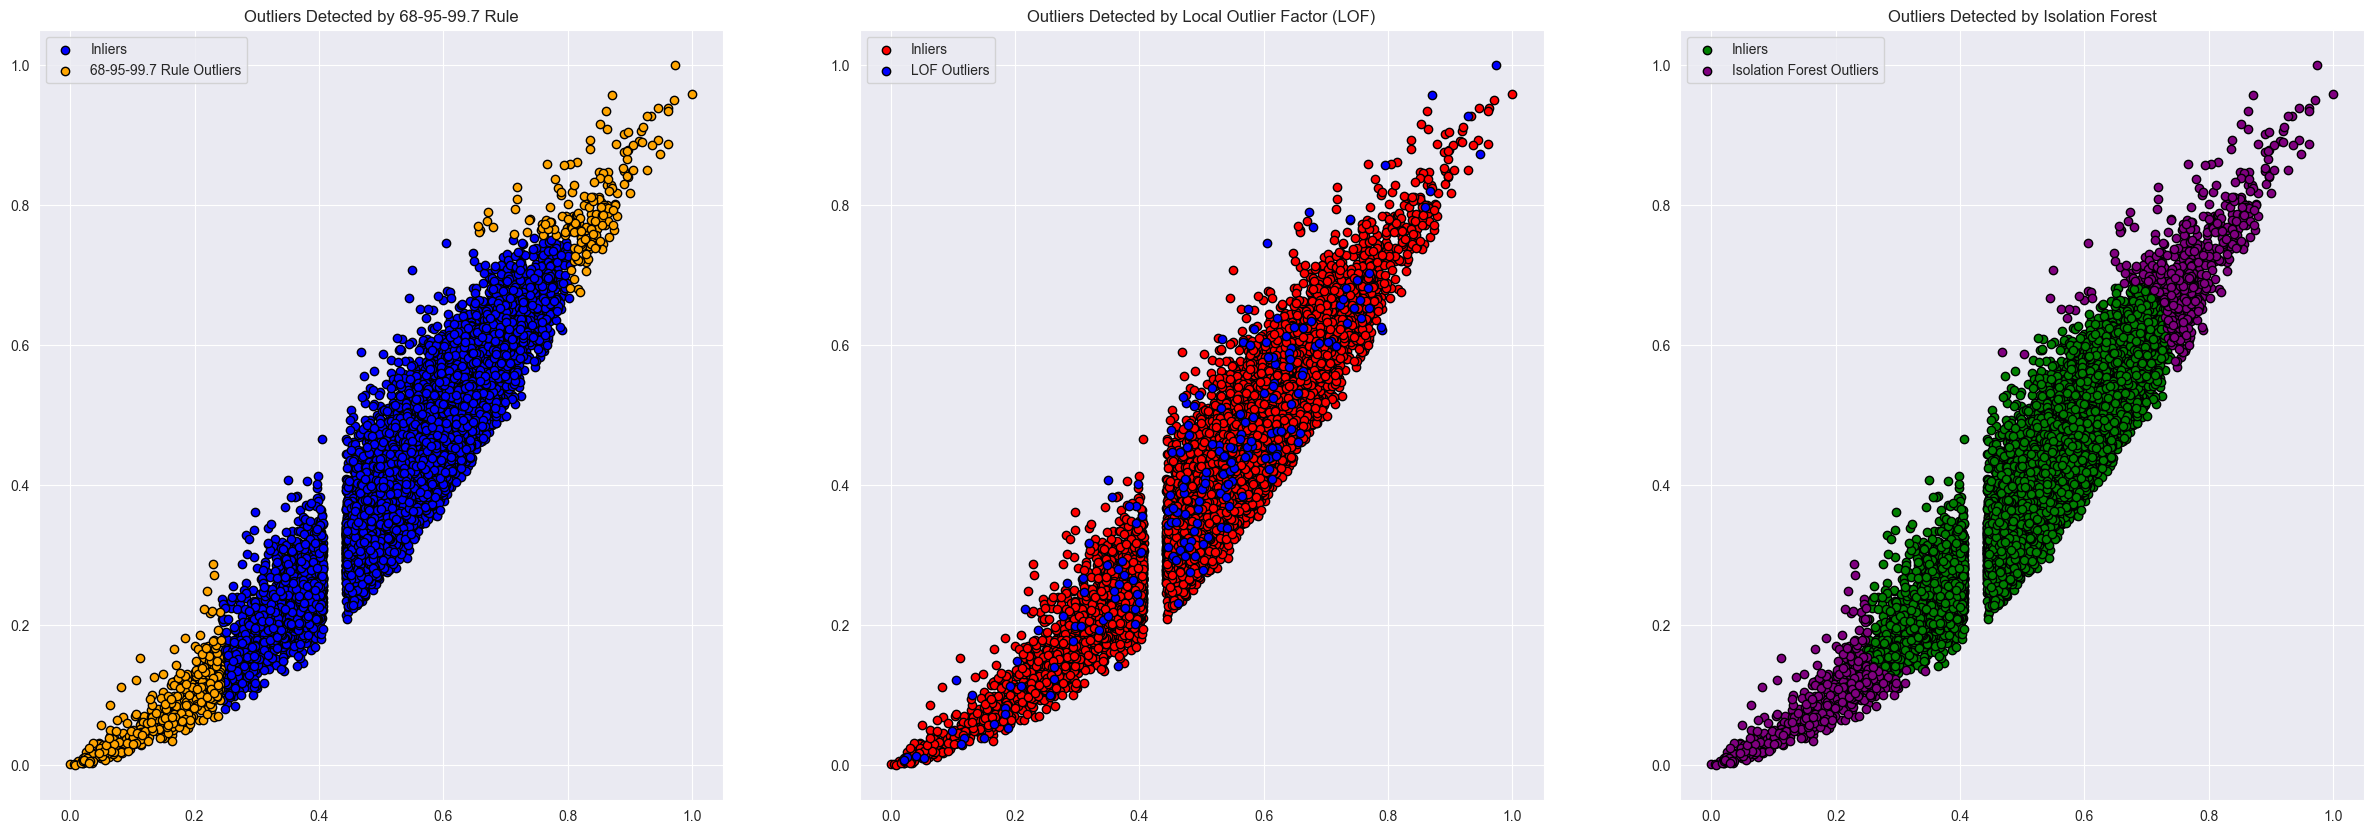

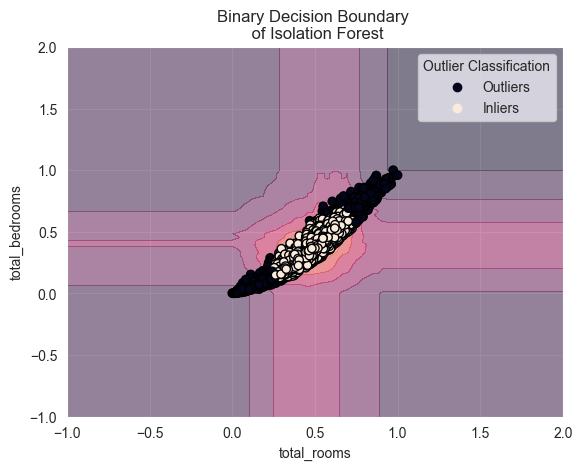

68-95-99.7 Rule - Number of Outliers Detected: 674
LOF - Number of Outliers Detected: 202
Isolation Forest - Number of Outliers Detected: 1130


In [166]:
# Choose the two features to plot
feature_1 = houses_preprocessed.columns[3]  # replace with actual feature if different
feature_2 = houses_preprocessed.columns[4]  # replace with actual feature if different

# Calculate the median and MAD for each selected feature
median_1 = houses_preprocessed[feature_1].median()
mad_1 = 1.4826 * (houses_preprocessed[feature_1] - median_1).abs().median()  # Scaled MAD

median_2 = houses_preprocessed[feature_2].median()
mad_2 = 1.4826 * (houses_preprocessed[feature_2] - median_2).abs().median()  # Scaled MAD

# Define the boundaries for outliers under the 68-95-99.7 rule with median and MAD
outliers_1 = ((houses_preprocessed[feature_1] < median_1 - 3 * mad_1) | 
              (houses_preprocessed[feature_1] > median_1 + 3 * mad_1))
outliers_2 = ((houses_preprocessed[feature_2] < median_2 - 3 * mad_2) | 
              (houses_preprocessed[feature_2] > median_2 + 3 * mad_2))

# Combine conditions to identify outliers based on the 68-95-99.7 rule with median and MAD
rule_outliers = houses_preprocessed[outliers_1 | outliers_2]
rule_inliers = houses_preprocessed[~(outliers_1 | outliers_2)]

# Step 2: Apply Local Outlier Factor (LOF) for outlier detection
clf_LOF = LocalOutlierFactor(n_neighbors=11)
y_pred = clf_LOF.fit_predict(houses_preprocessed)
x_scores = clf_LOF.negative_outlier_factor_

# Identify the LOF-detected outliers and inliers
lof_outliers = houses_preprocessed[y_pred == -1]
lof_inliers = houses_preprocessed[y_pred == 1]

# Step 3: Apply Isolation Forest for outlier detection
# Prepare data for Isolation Forest by selecting only the two chosen features
X = houses_preprocessed[[feature_1, feature_2]]

# Initialize and fit the Isolation Forest model
clf_IF = IsolationForest(n_estimators=150, max_samples='auto', contamination=0.075, random_state=0)
y_pred = clf_IF.fit_predict(X)  # Predict -1 for outliers and 1 for inliers

# Separate outliers and inliers based on Isolation Forest predictions
iso_outliers = X[y_pred == -1]
iso_inliers = X[y_pred == 1]

# Visualization setup
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

# First Plot: 68-95-99.7 Rule Outliers
ax[0].scatter(rule_inliers[feature_1], rule_inliers[feature_2], c='blue', label="Inliers", edgecolor="k")
ax[0].scatter(rule_outliers[feature_1], rule_outliers[feature_2], c='orange', label="68-95-99.7 Rule Outliers", edgecolor="k")
ax[0].set_title("Outliers Detected by 68-95-99.7 Rule")
ax[0].legend()

# Second Plot: LOF Outliers
ax[1].scatter(lof_inliers[feature_1], lof_inliers[feature_2], c='red', label="Inliers", edgecolor="k")
ax[1].scatter(lof_outliers[feature_1], lof_outliers[feature_2], c='blue', label="LOF Outliers", edgecolor="k")
ax[1].set_title("Outliers Detected by Local Outlier Factor (LOF)")
ax[1].legend()

# Third Plot: Isolation Forest Outliers
ax[2].scatter(iso_inliers[feature_1], iso_inliers[feature_2], c='green', label="Inliers", edgecolor="k")
ax[2].scatter(iso_outliers[feature_1], iso_outliers[feature_2], c='purple', label="Isolation Forest Outliers", edgecolor="k")
ax[2].set_title("Outliers Detected by Isolation Forest")
ax[2].legend()

# Plot Isolation Forest decision boundary (for visualization with 2D data)
from sklearn.inspection import DecisionBoundaryDisplay
disp = DecisionBoundaryDisplay.from_estimator(
    clf_IF,
    X,
    response_method="decision_function",
    alpha=0.5,
)
scatter = disp.ax_.scatter(X[feature_1], X[feature_2], c=y_pred, edgecolor="k")
disp.ax_.set_title("Binary Decision Boundary \n of Isolation Forest")
handles, labels = scatter.legend_elements()
plt.legend(handles=handles, labels=["Outliers", "Inliers"], title="Outlier Classification")

plt.show()


# Summary of results
print("68-95-99.7 Rule - Number of Outliers Detected:", len(rule_outliers))
print("LOF - Number of Outliers Detected:", len(lof_outliers))
print("Isolation Forest - Number of Outliers Detected:", len(iso_outliers))

### 3. Imputation [10]
- Identify which features should be imputed and which should be removed
  - Provide a written rationale for this decision
- Impute the missing records using KNN imputation
- Impute the missing records using MICE imputation
- Compare both imputed datasets feature distributions against each other and the non-imputed data
- Build a regressor on all thre datasets
  - Use regression models to predict house median price
  - Compare regressors of non-imputed data against imputed datas
  - **Note**: If you're struggling to compare against the original dataset focus on comparing the two imputed datasets against each other


In [150]:
# Calculate the percentage of missing data for each column
missing_percentage = (houses_corrupted.isnull().sum() / len(houses_corrupted.index)) * 100

# Calculate the actual data percentage (100% - missing percentage)
actual_data_percentage = 100 - missing_percentage

# Combine both into a summary DataFrame
missing_summary = pd.DataFrame({
    'Missing Percentage': missing_percentage,
    'Actual Data Percentage': actual_data_percentage
})

# Display the results
print("Percentage of Missing Data vs. Actual Data:")
print(missing_summary)

Percentage of Missing Data vs. Actual Data:
                    Missing Percentage  Actual Data Percentage
median_house_value                 0.0                   100.0
median_income                     10.0                    90.0
housing_median_age                10.0                    90.0
total_rooms                        0.0                   100.0
total_bedrooms                     0.0                   100.0
population                        10.0                    90.0
households                         0.0                   100.0
latitude                           0.0                   100.0
longitude                          0.0                   100.0


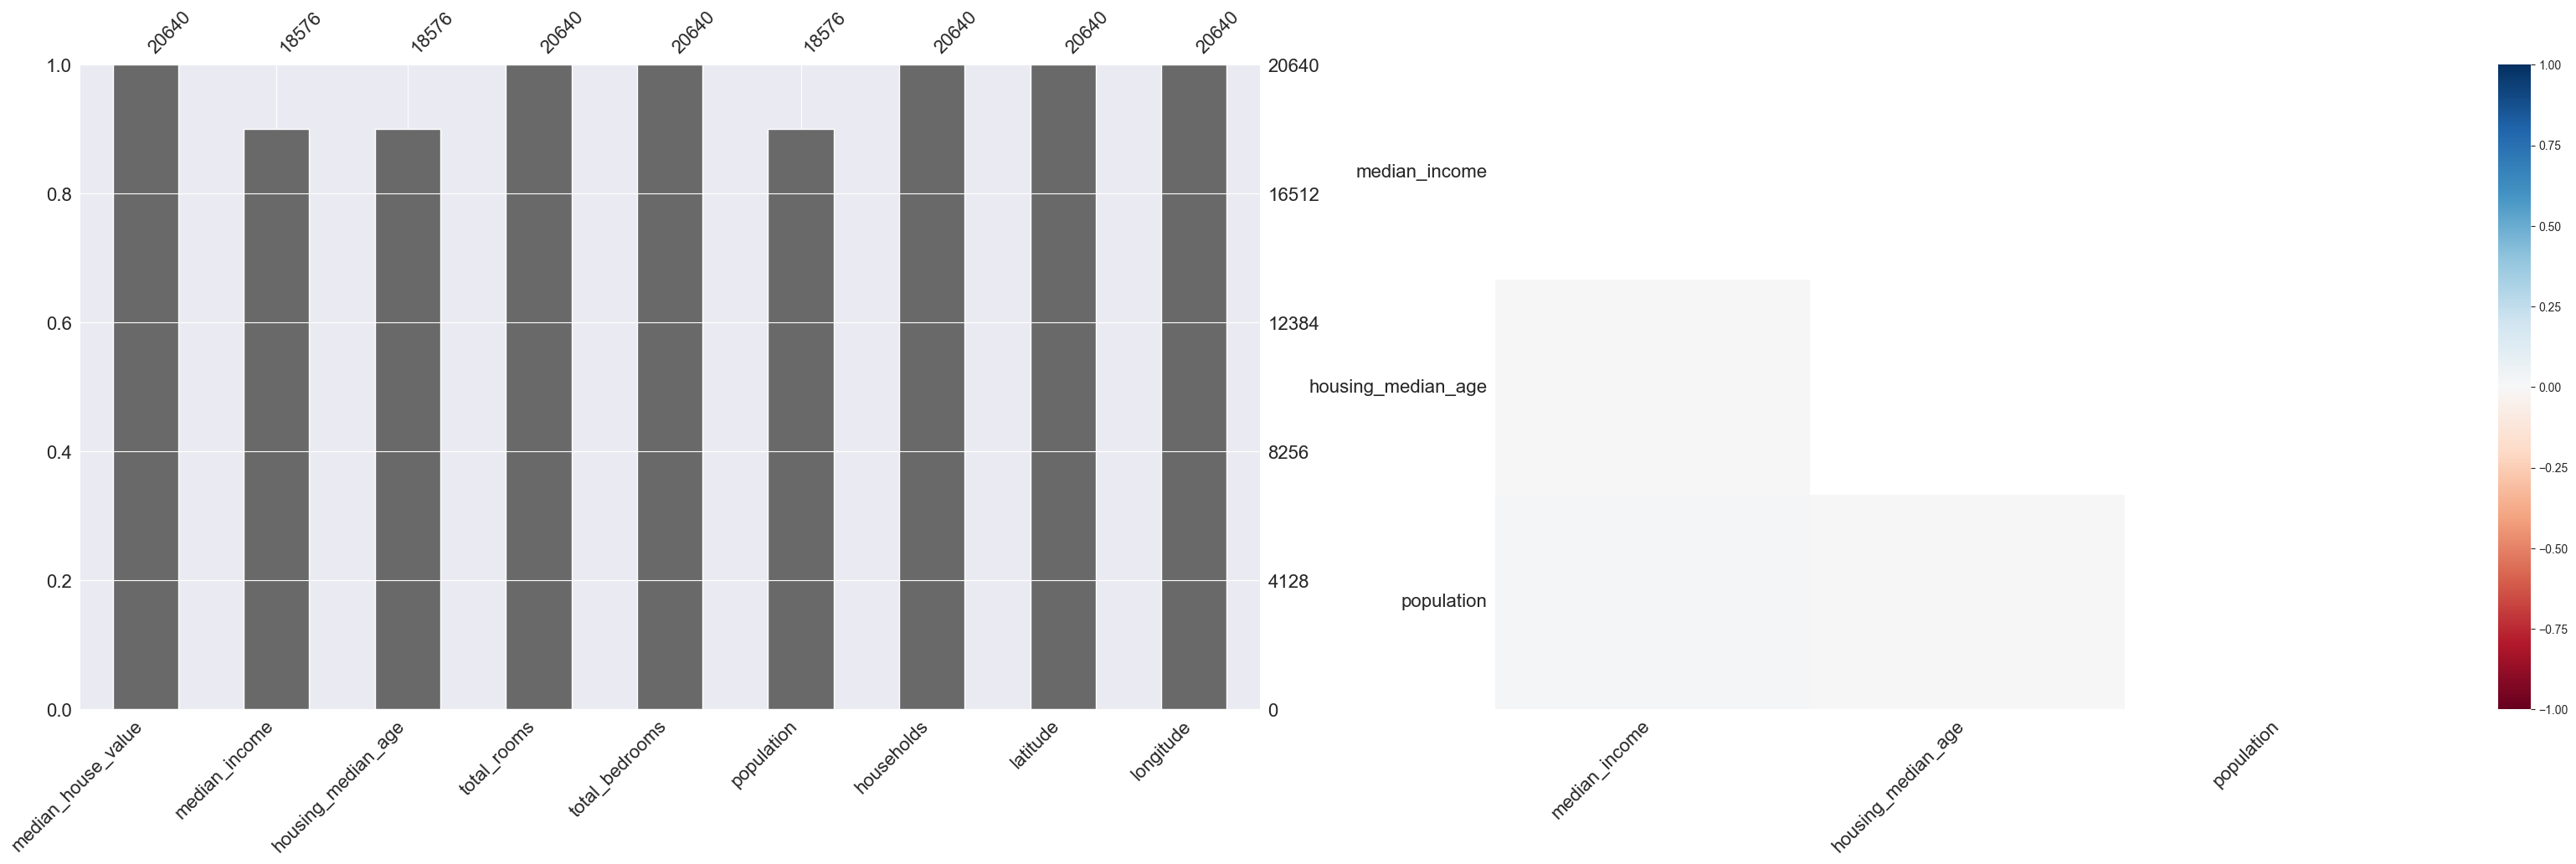

In [163]:
missing_summary = missing_summary.sort_values(by='Missing Percentage', ascending=False)
fig, ax = plt.subplots(1, 2, figsize=(40, 10))
msno.bar(houses_corrupted, ax=ax[0])
msno.heatmap(houses_corrupted, ax=ax[1])
plt.show()

In [164]:
# Set thresholds for imputation and removal
impute_threshold = 30  # % threshold to consider for imputation
remove_threshold = 30  # % threshold to consider for removal

# Identify features to impute or remove
features_to_impute = missing_summary[missing_summary['Missing Percentage'] <= impute_threshold].index.tolist()
features_to_remove = missing_summary[missing_summary['Missing Percentage'] > remove_threshold].index.tolist()

print("Features recommended for imputation:", features_to_impute)
print("Features recommended for removal:", features_to_remove)

Features recommended for imputation: ['median_income', 'housing_median_age', 'population', 'median_house_value', 'total_rooms', 'total_bedrooms', 'households', 'latitude', 'longitude']
Features recommended for removal: []


KNN Imputation will replace missing values by averaging the values of the nearest neighbors, preserving the structure of the data.

In [167]:
# Initialize the KNN Imputer with a specified number of neighbors (e.g., 5)
knn_imputer = KNNImputer(n_neighbors=5)

# Perform KNN imputation on the dataset with missing values
houses_knn_imputed = knn_imputer.fit_transform(houses_corrupted)

# Convert back to DataFrame for easier handling
houses_knn_imputed = pd.DataFrame(houses_knn_imputed, columns=houses_corrupted.columns)

print("KNN Imputation completed.")

KNN Imputation completed.


MICE imputation models each feature with missing values as a function of other features and iteratively fills in the missing values.

In [169]:
# Initialize the Iterative Imputer (similar to MICE)
mice_imputer = IterativeImputer(max_iter=10, random_state=0)

# Perform MICE imputation on the dataset with missing values
houses_mice_imputed = mice_imputer.fit_transform(houses_corrupted)

# Convert back to DataFrame for easier handling
houses_mice_imputed = pd.DataFrame(houses_mice_imputed, columns=houses_corrupted.columns)

print("MICE Imputation completed.")

MICE Imputation completed.


In [173]:
# Summarize original, KNN-imputed, and MICE-imputed datasets
print("Original Data Summary:")
# Specify the columns you want to describe
columns_to_describe = ['median_income', 'housing_median_age', 'population']

# Generate the description for only these columns
print(houses_corrupted[columns_to_describe].describe())


Original Data Summary:
       median_income  housing_median_age    population
count   18576.000000        18576.000000  18576.000000
mean        3.929958           28.324182   1488.069283
std         1.964296           12.584914   1170.585810
min         0.499900            1.000000      3.000000
25%         2.560300           18.000000    839.000000
50%         3.572400           28.000000   1227.000000
75%         4.870050           37.000000   1803.000000
max        15.000100           52.000000  35682.000000


In [174]:
print("\nKNN-Imputed Data Summary:")
# Specify the columns you want to describe
columns_to_describe = ['median_income', 'housing_median_age', 'population']

# Generate the description for only these columns
print(houses_knn_imputed[columns_to_describe].describe())


KNN-Imputed Data Summary:
       median_income  housing_median_age    population
count   20640.000000        20640.000000  20640.000000
mean        3.866952           28.670930   1425.563750
std         1.877780           12.135623   1128.229182
min         0.499900            1.000000      3.000000
25%         2.636260           19.000000    808.000000
50%         3.479200           29.000000   1152.000000
75%         4.679625           37.000000   1714.000000
max        15.000100           52.000000  35682.000000


In [175]:
print("\nMICE-Imputed Data Summary:")
# Specify the columns you want to describe
columns_to_describe = ['median_income', 'housing_median_age', 'population']

# Generate the description for only these columns
print(houses_mice_imputed[columns_to_describe].describe())


MICE-Imputed Data Summary:
       median_income  housing_median_age    population
count   20640.000000        20640.000000  20640.000000
mean        3.861578           28.480605   1422.852007
std         1.889705           12.024984   1130.243959
min        -1.667301            1.000000   -232.582073
25%         2.600000           19.000000    811.000000
50%         3.504200           29.000000   1152.000000
75%         4.693700           36.000000   1714.000000
max        15.000100           52.000000  35682.000000


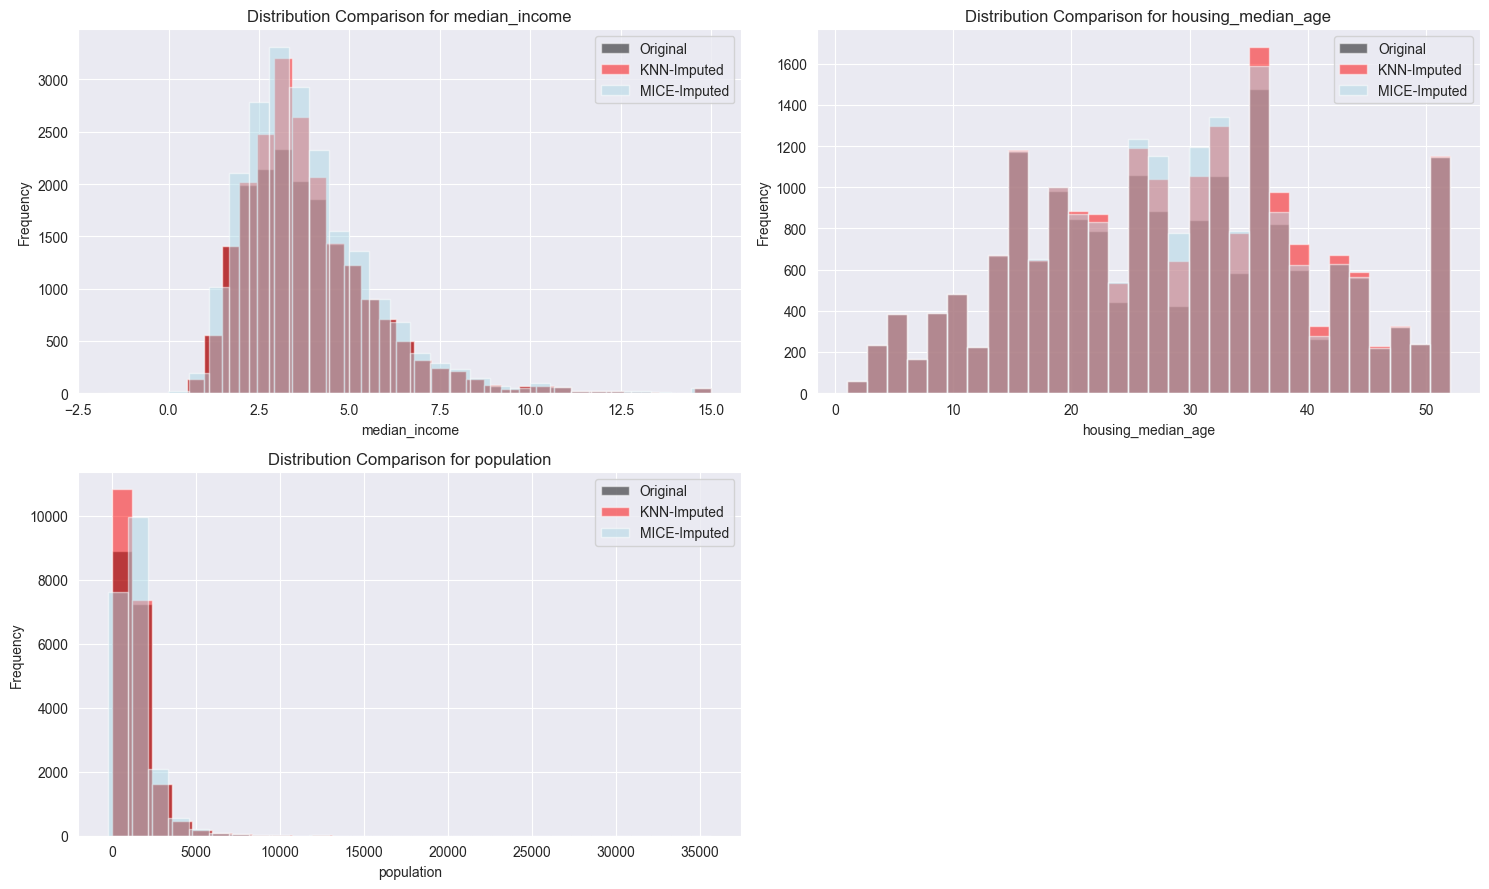

In [180]:
features_to_plot = houses_corrupted[columns_to_describe].columns

# Set up the figure with subplots (adjust rows and columns as needed)
num_features = len(features_to_plot)
fig, axes = plt.subplots(nrows=(num_features // 2) + (num_features % 2), ncols=2, figsize=(15, num_features * 3))

# Flatten axes for easy iteration if it's a 2D array
axes = axes.flatten()

# Define colors for each dataset
colors = {
    'Original': 'black',
    'KNN-Imputed': 'red',
    'MICE-Imputed': 'lightblue'
}

# Loop through each feature and plot on a subplot
for i, feature in enumerate(features_to_plot):
    # Select the current axis
    ax = axes[i]

    # Plot histograms for original, KNN-imputed, and MICE-imputed datasets with custom colors
    ax.hist(houses_corrupted[feature].dropna(), bins=30, alpha=0.5, color=colors['Original'], label='Original')
    ax.hist(houses_knn_imputed[feature], bins=30, alpha=0.5, color=colors['KNN-Imputed'], label='KNN-Imputed')
    ax.hist(houses_mice_imputed[feature], bins=30, alpha=0.5, color=colors['MICE-Imputed'], label='MICE-Imputed')
    
    # Set title and labels
    ax.set_title(f'Distribution Comparison for {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.legend()

# Hide any unused subplots if the number of features is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
# Use this dataset for comparison against the imputed datasets
houses = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv', header=0)

### 4. Conclusions & Throughts [3]
- Disucss methods used for anomaly detection, pros/cons of each method
- Disucss challenges/difficulties in anomaly detection implementation
- Discuss methods used for imputation, pros/cons of each method
- Discuss challenges/difficulties in imputation implementation